# Training

variable need to set up: <br>
dict_size (dictionary size) <br>
lambda (sparsity regularization) <br>
maybe patch_size (image patch size) <br>
nSmp (number of patches to sample) <br>
upscale (upscale factor) <br>

In [218]:
# -*- coding:utf-8 -*-
import os
import numpy as np
from skimage.color import rgb2ycbcr
from skimage.color import ycbcr2rgb
from skimage.measure import compare_psnr
from skimage.measure import compare_ssim
from scipy.misc import imresize
from scipy.signal import convolve
from skimage.util import view_as_windows
import  skimage.io as io
from skimage import data_dir
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import sparse_encode
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import spams

dic_size = 1024
Lambda = 0.2
upscale = 3
nSmp = 50000
patch_size = 5
overlap = 4

## ramdomly sample image patches <br>
patches_size, nSmp, upscale, img_path

read images from img_path

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


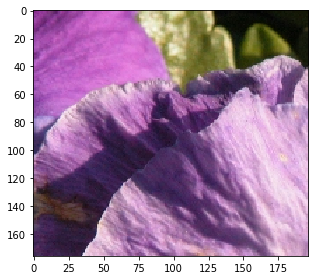

In [219]:
str = '/Users/shanlinsun/Desktop/USC/2018_Summer/ScSR/Data/Training/*.bmp'
coll = io.ImageCollection(str)
io.imshow(coll[0])

tune the nSmp of each image based on the size of each image

In [220]:
nSmp_array = np.zeros(len(coll))
nShape_array = np.zeros(len(coll))
for i in range(len(coll)):
    nShape_array[i] = coll[i].size
nSmp_array = np.floor(nSmp*nShape_array/sum(nShape_array))

### slice out patches from images

In [221]:
Xl = np.zeros(shape=(sum(nSmp_array.astype(int)),100))
Xh = np.zeros(shape=(sum(nSmp_array.astype(int)),25))

idx_cnt = 0
for i in range(len(coll)):
    
    # convert rgb image to YCcCr color space
    if coll[i].shape[2] == 3:
        H_Img = rgb2ycbcr(coll[i])
        # only keep y-channle for 'texture'
        H_Img = H_Img[:,:,0]
    else:
        H_Img = coll[i]
    
    # create low-res images by resize up and down
    L_Img = imresize(H_Img, 1/upscale, interp='bicubic', mode = 'F')
    L_Img = imresize(L_Img, H_Img.shape, interp='bicubic', mode = 'F')
    L_Img = L_Img.astype(float)
    
    # compute first order and second order gradient, 
    # generating four feature maps per low-resolution image
    L_Img_1 = convolve(L_Img, [[-1,0,1]], 'same')
    L_Img_2 = convolve(L_Img, [[-1],[0],[1]], 'same')
    L_Img_3 = convolve(L_Img, [[1,0,-2,0,1]], 'same')
    L_Img_4 = convolve(L_Img, [[1],[0],[-2],[0],[1]], 'same')
    
    # slice out low-res patches
    patch_array_1 = view_as_windows(L_Img_1, 5)
    patch_array_1 = patch_array_1.reshape(-1, patch_array_1.shape[-2]*patch_array_1.shape[-1])
    patch_array_2 = view_as_windows(L_Img_2, 5)
    patch_array_2 = patch_array_2.reshape(-1, patch_array_2.shape[-2]*patch_array_2.shape[-1])
    patch_array_3 = view_as_windows(L_Img_3, 5)
    patch_array_3 = patch_array_3.reshape(-1, patch_array_3.shape[-2]*patch_array_3.shape[-1])
    patch_array_4 = view_as_windows(L_Img_4, 5)
    patch_array_4 = patch_array_4.reshape(-1, patch_array_4.shape[-2]*patch_array_4.shape[-1])
    # slice out high-res patches
    patch_array_h = view_as_windows(H_Img, 5)
    patch_array_h = patch_array_h.reshape(-1, patch_array_h.shape[-2]*patch_array_h.shape[-1])
    # get the index of target patches
    idx = np.arange(patch_array_1.shape[0])
    np.random.shuffle(idx)
    # get the nSmp_array[i] patches from low-res image
    patch_array_1 = patch_array_1[idx[:nSmp_array[i].astype(int)],:]
    patch_array_2 = patch_array_2[idx[:nSmp_array[i].astype(int)],:]
    patch_array_3 = patch_array_3[idx[:nSmp_array[i].astype(int)],:]
    patch_array_4 = patch_array_4[idx[:nSmp_array[i].astype(int)],:]
    # get the nSmp_array[i] patches from high-res image
    patch_array_h = patch_array_h[idx[:nSmp_array[i].astype(int)],:]
    patch_array_h = patch_array_h
    # stack four feature maps of low-res image together
    patch_array_l = np.concatenate((patch_array_1,patch_array_2,patch_array_3,patch_array_4),axis = 1)
    # subtract patch mean from high-res each patch
    m = np.mean(patch_array_h, axis=1)
    m = (np.tile(m,(patch_array_h.shape[1],1))).T
    patch_array_h = patch_array_h-m
    
    # append the new patch array to the patch dictionaries
    Xl[idx_cnt:idx_cnt+nSmp_array[i].astype(int),:] = patch_array_l
    Xh[idx_cnt:idx_cnt+nSmp_array[i].astype(int),:] = patch_array_h
    idx_cnt += nSmp_array[i].astype(int)

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()
/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


[optional] save patches arrays

## patches pruning, low variance removal<br>
threshold

In [222]:
threshold = 10
idx = np.var(Xh,1)>10
Xl = Xl[idx,:].round()
Xh = Xh[idx,:]

## train coupled dictionary<br>
low-res patches array, high-res patches array<br>
dict-size, lambda

pre-processing<br>
patch normalization (sum the column, sqrt it, divide it, seperately done for high-res and low-res patches array)

In [223]:
lnorm = np.sqrt(np.sum(np.power(Xl,2),1))
hnorm = np.sqrt(np.sum(np.power(Xh,2),1))
L_norm = (np.tile(lnorm,(Xl.shape[1],1))).T
Xl_norm = np.divide(Xl,L_norm)
H_norm = (np.tile(hnorm,(Xh.shape[1],1))).T
Xh_norm = np.divide(Xh,H_norm)

X = [sqrt(hDim)*Xh_norm; sqrt(lDim)*Xl_norm], combine normalized high-res patches array and low-res patches array

In [224]:
hDim = 25
lDim = 100
X = np.concatenate((np.sqrt(hDim)*Xh_norm,np.sqrt(lDim)*Xl_norm),axis = 1)

normalize the new-built X

In [225]:
dnorm = np.sqrt(np.sum(np.power(X,2),1))
X_norm = (np.tile(dnorm,(X.shape[1],1))).T
X = np.divide(X,X_norm)

In [226]:
savemat('/Users/shanlinsun/Desktop/USC/2018_Summer/ScSR/Data/X.mat',mdict={'X':X.T})

spase coding (sklearn)

In [227]:
Dic = MiniBatchDictionaryLearning(n_components = dic_size, alpha = 0.1, batch_size = 2000, n_iter = 100)
SrDc = Dic.fit(X)

split the X into two dictionary Xh and Xl

In [228]:
Dh = SrDc.components_[:,:25]
Dl = SrDc.components_[:,25:]

[optional] save yout dictionaries

In [229]:
joblib.dump(SrDc, 'Dictionary/Dic_1024_0.1_2000_100_100000_3')

['Dictionary/Dic_1024_0.1_2000_100_100000_3']

# Testing

[optional] load dictionary

In [230]:
SrDc = joblib.load('Dictionary/Dic_1024_0.1_2000_100_100000_3')
Dh = SrDc.components_[:,:25]
Dl = SrDc.components_[:,25:]

read the test image

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


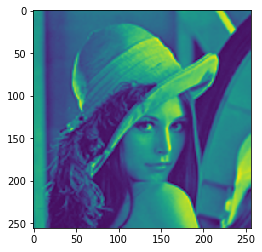

In [244]:
Gnd_Img = io.imread('/Users/shanlinsun/Desktop/USC/2018_Summer/ScSR/Data/Testing/gnd.bmp')
Gnd_Img_ycbcr = rgb2ycbcr(Gnd_Img)
T_Img = imresize(Gnd_Img_ycbcr[:,:,0],1/upscale, interp='bicubic', mode = 'F')
Bi_Img = imresize(T_Img_ycbcr[:,:,0],(Gnd_Img.shape[0],Gnd_Img.shape[1]), interp='bicubic', mode = 'F')
plt.imshow(Bi_Img)

convert rgb image to ycbcr image, only use the y-channel image only later

[[131.59678824 131.44735294 129.6318     ...  98.16450588  98.64115294
   99.81774118]
 [131.43790588 129.72025882 127.14378824 ...  97.71190588 100.87237647
  100.52712941]
 [128.70255294 127.42805882 123.74542353 ...  97.7308      99.01474118
   82.27541176]
 ...
 [115.38048235 129.40249412 135.47523529 ...  65.82894118  58.01965882
   56.95042353]
 [115.19411765 129.30458824 134.51850588 ...  57.77231765  55.06444706
   57.35664706]
 [113.41549412 129.24361176 133.14610588 ...  54.00981176  55.06444706
   57.95868235]]


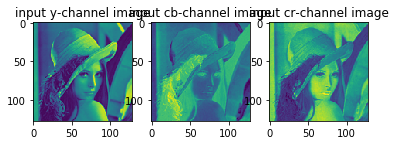

In [232]:
Test_Img = rgb2ycbcr(Test_Img)
Test_Img_y = Test_Img[:,:,0]
Test_Img_cb = Test_Img[:,:,1]
Test_Img_cr = Test_Img[:,:,2]
plt.subplot(1,3,1)
plt.title('input y-channel image')
plt.imshow(Test_Img_y)
plt.subplot(1,3,2)
plt.title('input cb-channel image')
plt.imshow(Test_Img_cb)
plt.subplot(1,3,3)
plt.title('input cr-channel image')
plt.imshow(Test_Img_cr)
print(Test_Img_y)

## ScSR<br>
up_scale<br>
lambda<br>
overlap, the lager the better result

normalize the dictionary, like before

In [245]:
lnorm = np.sqrt(np.sum(np.power(Dl,2),1))
L_norm = (np.tile(lnorm,(Dl.shape[1],1))).T
Dl_norm = np.divide(Dl,L_norm)

patch_size should match the dictionary

enlarge the image using 'bicubic' interpolation (注意精度)

In [246]:
M_Img = np.pad(Bi_Img, overlap, mode='symmetric')
H_Img = np.zeros(M_Img.shape)

extract one order and second order graident features of the low-res image as before

In [247]:
M_Img_1 = convolve(M_Img, [[-1,0,1]], 'same')
M_Img_2 = convolve(M_Img, [[-1],[0],[1]], 'same')
M_Img_3 = convolve(M_Img, [[1,0,-2,0,1]], 'same')
M_Img_4 = convolve(M_Img, [[1],[0],[-2],[0],[1]], 'same')

padding the med-red image for the constant number of overlapping of all pixels

In [248]:
M_Img_all = np.stack((M_Img_1,M_Img_2,M_Img_3,M_Img_4))

slice out the patches from the med-res image

In [249]:
gridx = np.arange(0, M_Img_1.shape[0]-patch_size+1,\
                  patch_size-overlap, dtype=int)
gridy = np.arange(0, M_Img_1.shape[1]-patch_size+1,\
                  patch_size-overlap, dtype=int)

In [250]:
for xx in gridx:
    for yy in gridy:
        # get the upper left index of each patch
        #xx = gridx[i]
        #yy = gridy[j]
        # compute the mean and normal scale of each patch
        mPatch = M_Img[xx:xx+patch_size,yy:yy+patch_size]
        m_Mean = np.mean(mPatch)
        mPatch = mPatch - m_Mean
        mNorm = np.sqrt(np.sum(np.power(mPatch,2)))
        # preprocessing gradient map
        mPatchFea_1 = M_Img_1[xx:xx+patch_size,yy:yy+patch_size]
        mPatchFea_1 = mPatchFea_1.flatten()
        mPatchFea_2 = M_Img_2[xx:xx+patch_size,yy:yy+patch_size]
        mPatchFea_2 = mPatchFea_2.flatten()
        mPatchFea_3 = M_Img_3[xx:xx+patch_size,yy:yy+patch_size]
        mPatchFea_3 = mPatchFea_3.flatten()
        mPatchFea_4 = M_Img_4[xx:xx+patch_size,yy:yy+patch_size]
        mPatchFea_4 = mPatchFea_4.flatten()
        mPatchFea = np.concatenate((mPatchFea_1, mPatchFea_2, mPatchFea_3, mPatchFea_4))
        mfNorm = np.sqrt(np.sum(np.power(mPatchFea,2)))
        
        if mfNorm > 1:
            y = mPatchFea/mfNorm
        else:
            y = mPatchFea
            
        # reshape y for sparse coder requirement
        y = y.reshape(1,-1)    
        # sparse recovery
        w = sparse_encode(y, Dl, alpha=0.1, max_iter = 50)
        #w = spams.lasso(y.T,D = Dl.T,return_reg_path = False,**param)
        
        hPatch = np.dot(w,Dh)
        
        # normalize the high-res patch
        hNorm = np.sqrt(np.sum(np.power(hPatch,2)))
        
        if hNorm:
            s = mNorm*1.2/(hNorm)
            hPatch = s*hPatch
        
        # reshape back to the (patch_size,patch_size) patch 
        hPatch = hPatch.reshape(patch_size, patch_size)
        # insert the patch into the high-res image
        hPatch = hPatch + m_Mean
        H_Img[xx:xx+patch_size,yy:yy+patch_size] += hPatch

plot the primitive sup-res image

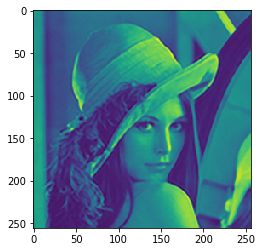

In [251]:
h_Img = H_Img[patch_size-1:-patch_size+1,patch_size-1:-patch_size+1]/25
plt.imshow(h_Img)

read the ground truth image

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


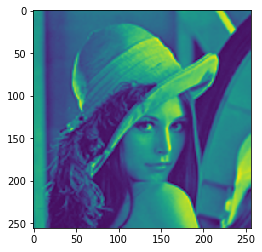

In [252]:
Gnd_Img = io.imread('/Users/shanlinsun/Desktop/USC/2018_Summer/ScSR/Data/Testing/gnd.bmp')
Gnd_Img_ycbcr = rgb2ycbcr(Gnd_Img)
T_Img = io.imread('/Users/shanlinsun/Desktop/USC/2018_Summer/ScSR/Data/Testing/input.bmp')
T_Img_ycbcr = rgb2ycbcr(T_Img)
Bi_Img = imresize(T_Img_ycbcr[:,:,0],(Gnd_Img.shape[0],Gnd_Img.shape[1]), interp='bicubic', mode = 'F')
plt.imshow(Bi_Img)

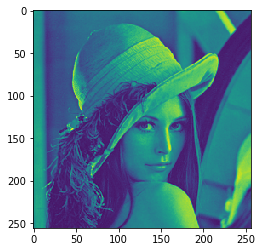

In [253]:
plt.imshow(Gnd_Img_ycbcr[:,:,0])

plot the difference between ground-truth image and sup-res image

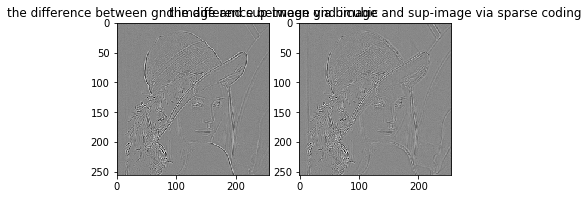

In [254]:
plt.subplot(1,2,1)
plt.title('the difference between gnd image and sup-image via bicubic')
plt.imshow(Bi_Img-Gnd_Img_ycbcr[:,:,0],cmap = 'gray')
plt.subplot(1,2,2)
plt.title('the difference between gnd image and sup-image via sparse coding')
plt.imshow(h_Img-Gnd_Img_ycbcr[:,:,0],cmap = 'gray')

# Result evaluation

In [255]:
psnr = compare_psnr(Gnd_Img_ycbcr[:,:,0].astype(float),h_Img.astype(float),data_range=h_Img.max() - h_Img.min())
ssim = compare_ssim(Gnd_Img_ycbcr[:,:,0].astype(float),h_Img.astype(float),data_range=h_Img.max() - h_Img.min())
print('srsc_v1_upscale_2, psnr:', psnr)
print('srsc_v1_upscale_2, ssim:', ssim)

srsc_v1_upscale_2, psnr: 30.733904333070953
srsc_v1_upscale_2, ssim: 0.9115947829423102


In [256]:
psnr = compare_psnr(Gnd_Img_ycbcr[:,:,0].astype(float),Bi_Img.astype(float),data_range=Bi_Img.max() - Bi_Img.min())
ssim = compare_ssim(Gnd_Img_ycbcr[:,:,0].astype(float),Bi_Img.astype(float),data_range=Bi_Img.max() - Bi_Img.min())
print('bicubic_upscale_2, psnr:', psnr)
print('bicubic_upscale_2, ssim:', ssim)

bicubic_upscale_2, psnr: 28.97314295106966
bicubic_upscale_2, ssim: 0.8954265719724004
